In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-yield-in-indian-states-dataset/crop_yield.csv


In [2]:
# -------------------------
# PHASE 3 — CLEAN SETUP
# -------------------------

import os
import numpy as np
import pandas as pd

# Create project folders
MODEL_DIR = "/kaggle/working/models"
PREPROCESS_DIR = "/kaggle/working/preprocessing"
SHAP_DIR = "/kaggle/working/shap_background"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(SHAP_DIR, exist_ok=True)

print("Folders created:")
print(MODEL_DIR)
print(PREPROCESS_DIR)
print(SHAP_DIR)

# Load dataset
DATA_PATH = "/kaggle/input/crop-yield-in-indian-states-dataset/crop_yield.csv"
df = pd.read_csv(DATA_PATH)

print("\nDataset Loaded. Shape:", df.shape)
df.head()


Folders created:
/kaggle/working/models
/kaggle/working/preprocessing
/kaggle/working/shap_background

Dataset Loaded. Shape: (19689, 10)


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [3]:
# -----------------------------
# PHASE 3 — STEP 1: CLEAN DATASET FOR MAIN CROPS
# -----------------------------

main_crops = [
    "Wheat","Rice","Maize","Bajra","Jowar","Barley","Ragi","Small millets","Other Cereals",
    "Gram","Arhar/Tur","Masoor","Peas & beans (Pulses)","Moong(Green Gram)","Urad","Horse-gram",
    "Other Kharif pulses","Other  Rabi pulses",
    "Groundnut","Soyabean","Rapeseed &Mustard","Sunflower","Sesamum","Linseed","Castor seed",
    "Sugarcane","Cotton(lint)","Jute","Mesta","Tobacco",
    "Potato","Onion","Sweet potato"
]

# Filter dataset
df_main = df[df["Crop"].isin(main_crops)].copy()

print("Main crop dataset shape:", df_main.shape)

# Convert fertilizer & pesticide to per hectare
df_main["Fert_kg_ha"] = df_main["Fertilizer"] / df_main["Area"]
df_main["Pest_kg_ha"] = df_main["Pesticide"] / df_main["Area"]

# Fix impossible values (negative or zeros)
df_main = df_main[
    (df_main["Area"] > 0) &
    (df_main["Fert_kg_ha"] >= 0) &
    (df_main["Pest_kg_ha"] >= 0) &
    (df_main["Yield"] > 0)
].copy()

# Convert yield to tons/ha if too large (likely quintals)
df_main["Yield"] = np.where(
    (df_main["Yield"] > 50) & (df_main["Crop"] != "Sugarcane"),
    df_main["Yield"] / 10,
    df_main["Yield"]
)

# Preview clean data
df_main.head(10)


Main crop dataset shape: (15979, 10)


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield,Fert_kg_ha,Pest_kg_ha
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435,95.17,0.31
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333,95.17,0.31
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909,95.17,0.31
6,Gram,1997,Rabi,Assam,2979.0,1507,2051.4,283511.43,923.49,0.465455,95.17,0.31
7,Jute,1997,Kharif,Assam,94520.0,904095,2051.4,8995468.40,29301.20,9.919565,95.17,0.31
8,Linseed,1997,Rabi,Assam,10098.0,5158,2051.4,961026.66,3130.38,0.461364,95.17,0.31
9,Maize,1997,Kharif,Assam,19216.0,14721,2051.4,1828786.72,5956.96,0.615652,95.17,0.31
10,Mesta,1997,Kharif,Assam,5915.0,29003,2051.4,562930.55,1833.65,4.568947,95.17,0.31
12,Onion,1997,Whole Year,Assam,7832.0,17943,2051.4,745371.44,2427.92,2.342609,95.17,0.31
13,Other Rabi pulses,1997,Rabi,Assam,108297.0,58272,2051.4,10306625.49,33572.07,0.520870,95.17,0.31


In [4]:
# -----------------------------
# PHASE 3 — STEP 2: CROP-WISE OUTLIER REMOVAL
# -----------------------------

def remove_outliers_cropwise(df, column="Yield"):
    clean_df = pd.DataFrame()

    for crop in df["Crop"].unique():
        temp = df[df["Crop"] == crop].copy()

        Q1 = temp[column].quantile(0.25)
        Q3 = temp[column].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        filtered = temp[(temp[column] >= lower) & (temp[column] <= upper)]
        clean_df = pd.concat([clean_df, filtered], ignore_index=True)
    
    return clean_df

# Apply crop-wise outlier removal
df_clean = remove_outliers_cropwise(df_main)

print("Shape before:", df_main.shape)
print("Shape after outlier cleaning:", df_clean.shape)

df_clean.head()


Shape before: (15911, 12)
Shape after outlier cleaning: (15414, 12)


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield,Fert_kg_ha,Pest_kg_ha
0,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435,95.17,0.31
1,Arhar/Tur,1997,Kharif,Karnataka,421810.0,98473,1266.7,40143657.70,130761.10,0.268235,95.17,0.31
2,Arhar/Tur,1997,Kharif,Meghalaya,865.0,683,3818.2,82322.05,268.15,0.806667,95.17,0.31
3,Arhar/Tur,1997,Whole Year,West Bengal,3630.0,2181,1852.9,345467.10,1125.30,0.777692,95.17,0.31
4,Arhar/Tur,1998,Kharif,Assam,7657.0,5389,2354.4,756511.60,2220.53,0.709130,98.80,0.29


In [5]:
# ----------------------------------------
# PHASE 3 — STEP 3: TRAIN CROP-WISE MODELS
# ----------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

crop_list = df_clean["Crop"].unique()
print("Number of crops:", len(crop_list))
print("Training models for:", crop_list)

for crop in crop_list:
    print("\n========================================")
    print(f"Training model for: {crop}")
    print("========================================")

    # Filter dataset for this crop
    df_crop = df_clean[df_clean["Crop"] == crop].copy()

    # Features and target
    X = df_crop[["State", "Area", "Fert_kg_ha", "Pest_kg_ha", "Annual_Rainfall"]]
    y = df_crop["Yield"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ("state_encoder", OneHotEncoder(handle_unknown="ignore"), ["State"]),
            ("scale_num", StandardScaler(), ["Area", "Fert_kg_ha", "Pest_kg_ha", "Annual_Rainfall"])
        ],
        remainder="drop"
    )

    # Model
    model = RandomForestRegressor(
        n_estimators=250,
        random_state=42,
        n_jobs=-1
    )

    # Pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Save model
    file_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    joblib.dump(pipeline, file_path)

    print(f"Saved model to: {file_path}")
    print(f"Train sample size = {len(X_train)}")
    print(f"Test sample size = {len(X_test)}")
# === EVALUATION ===
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Save model
    file_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    joblib.dump(pipeline, file_path)

    print(f"Saved model to: {file_path}")
    print("----------------------------------------")

Number of crops: 33
Training models for: ['Arhar/Tur' 'Castor seed' 'Cotton(lint)' 'Gram' 'Jute' 'Linseed' 'Maize'
 'Mesta' 'Onion' 'Other  Rabi pulses' 'Potato' 'Rapeseed &Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tobacco' 'Wheat'
 'Bajra' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Soyabean' 'Barley'
 'Masoor' 'Moong(Green Gram)' 'Other Kharif pulses' 'Urad'
 'Peas & beans (Pulses)' 'Sunflower' 'Other Cereals']

Training model for: Arhar/Tur
Saved model to: /kaggle/working/models/Arhar_Tur.joblib
Train sample size = 387
Test sample size = 97
R² Score: 0.6683
MAE: 0.0974
RMSE: 0.1423
Saved model to: /kaggle/working/models/Arhar_Tur.joblib
----------------------------------------

Training model for: Castor seed
Saved model to: /kaggle/working/models/Castor seed.joblib
Train sample size = 222
Test sample size = 56
R² Score: 0.7528
MAE: 0.0754
RMSE: 0.1130
Saved model to: /kaggle/working/models/Castor seed.joblib
----------------------------------------

Traini

In [6]:
performance = []  # Add this above the for-loop
performance.append({
    "Crop": crop,
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse,
    "TrainSamples": len(X_train),
    "TestSamples": len(X_test)
})
perf_df = pd.DataFrame(performance)
perf_df


,Crop,R2,MAE,RMSE,TrainSamples,TestSamples
0,Other Cereals,0.382253,0.16882,0.221499,110,28


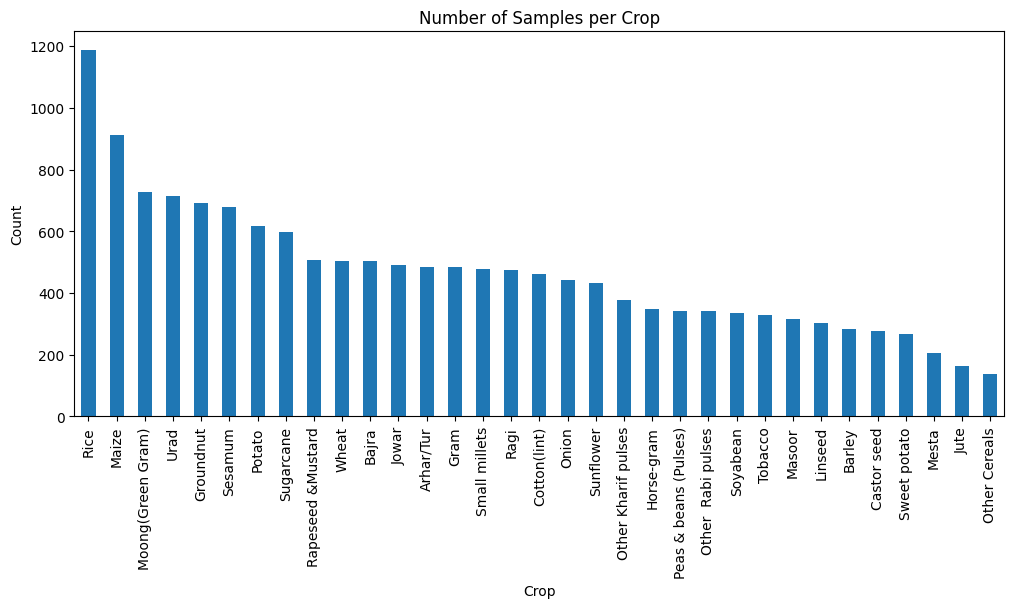

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
df_clean["Crop"].value_counts().plot(kind="bar")
plt.title("Number of Samples per Crop")
plt.xlabel("Crop")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


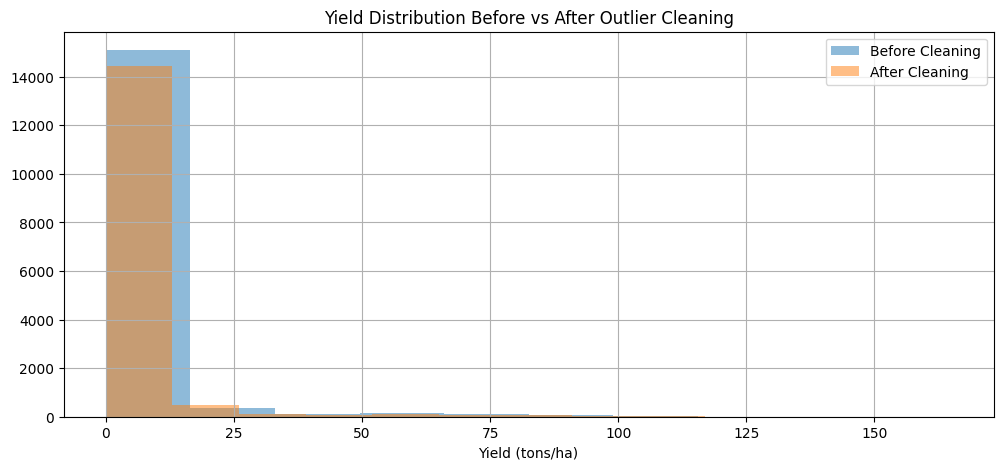

In [8]:
plt.figure(figsize=(12,5))
df_main["Yield"].hist(alpha=0.5, label="Before Cleaning")
df_clean["Yield"].hist(alpha=0.5, label="After Cleaning")
plt.title("Yield Distribution Before vs After Outlier Cleaning")
plt.xlabel("Yield (tons/ha)")
plt.legend()
plt.show()


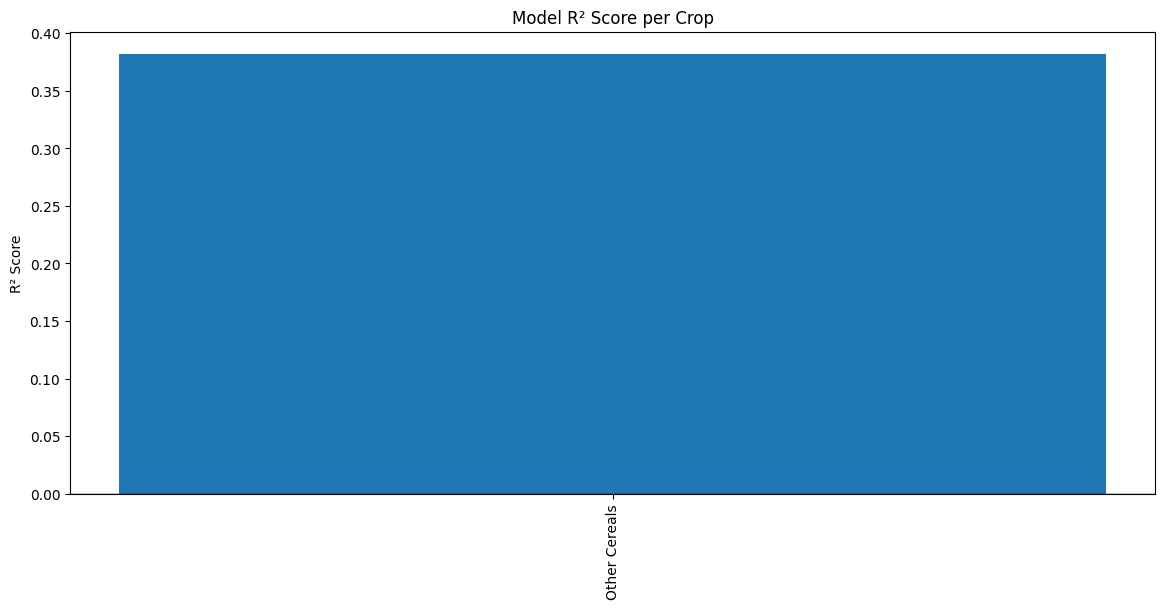

In [9]:
plt.figure(figsize=(14,6))
plt.bar(perf_df["Crop"], perf_df["R2"])
plt.title("Model R² Score per Crop")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.axhline(0, color="black", linewidth=1)
plt.show()


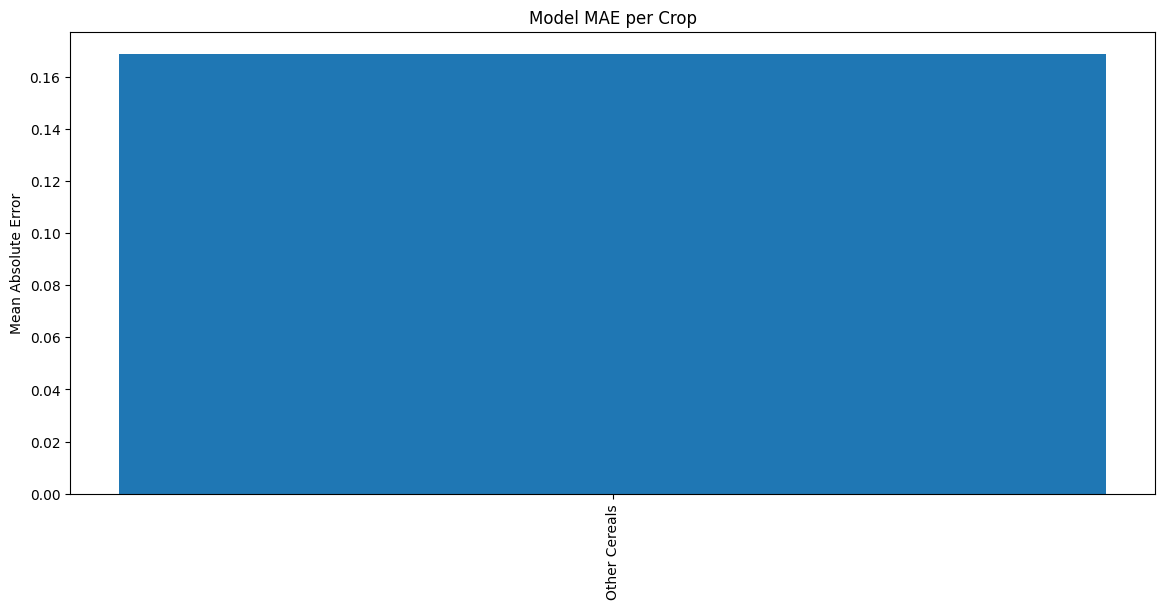

In [10]:
plt.figure(figsize=(14,6))
plt.bar(perf_df["Crop"], perf_df["MAE"])
plt.title("Model MAE per Crop")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=90)
plt.show()


In [11]:
# -------------------------------------------------------
# PHASE 3 — STEP 4: CROP-WISE INFERENCE ENGINE
# -------------------------------------------------------

import joblib

def predict_yield(state, crop, area, fertilizer, pesticide, rainfall):
    """
    Unified inference function.
    Loads the correct crop-specific model and returns predicted yield + total production.
    """

    # Convert per-hectare fertilizer & pesticide
    fert_ha = fertilizer / area
    pest_ha = pesticide / area

    # Build input dataframe
    input_df = pd.DataFrame([{
        "State": state,
        "Area": area,
        "Fert_kg_ha": fert_ha,
        "Pest_kg_ha": pest_ha,
        "Annual_Rainfall": rainfall
    }])

    # Load crop model
    model_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    pipeline = joblib.load(model_path)

    # Predict yield
    predicted_yield = pipeline.predict(input_df)[0]

    # Total production
    total_production = predicted_yield * area

    return predicted_yield, total_production


predict_yield("West Benga", "Wheat", 10, 800, 3, 1600)


(0.8816510673159995, 8.816510673159994)

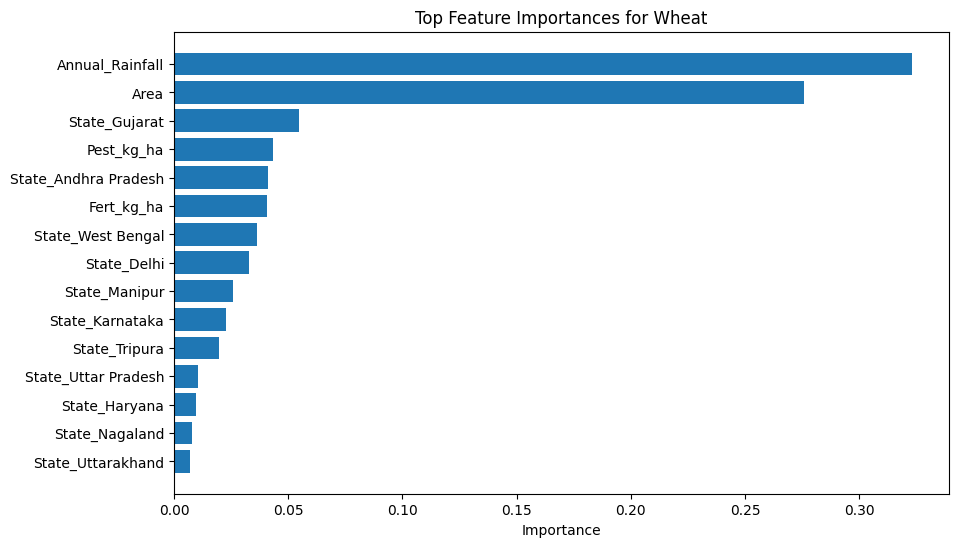

In [12]:
def plot_feature_importance(crop):
    model_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    pipeline = joblib.load(model_path)

    rf = pipeline.named_steps["model"]
    pre = pipeline.named_steps["preprocessor"]

    state_enc = pre.named_transformers_["state_encoder"]
    state_features = list(state_enc.get_feature_names_out(["State"]))

    numeric_features = ["Area", "Fert_kg_ha", "Pest_kg_ha", "Annual_Rainfall"]
    all_features = state_features + numeric_features

    importances = rf.feature_importances_

    idx = np.argsort(importances)[-15:]
    plt.figure(figsize=(10,6))
    plt.barh(np.array(all_features)[idx], importances[idx])
    plt.title(f"Top Feature Importances for {crop}")
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance("Wheat")



In [13]:
# -------------------------------------------------------
# PHASE 3 — STEP 5: SHAP EXPLANATION (PER CROP)
# -------------------------------------------------------

import shap

def explain_prediction(state, crop, area, fertilizer, pesticide, rainfall, background_size=50):
    """
    Returns sorted SHAP values for a single prediction using crop-specific model.
    """

    # Convert per hectare
    fert_ha = fertilizer / area
    pest_ha = pesticide / area

    input_df = pd.DataFrame([{
        "State": state,
        "Area": area,
        "Fert_kg_ha": fert_ha,
        "Pest_kg_ha": pest_ha,
        "Annual_Rainfall": rainfall
    }])

    # Load model
    model_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    pipeline = joblib.load(model_path)

    # Prepare background data (same crop only)
    df_crop = df_clean[df_clean["Crop"] == crop].sample(
        n=min(background_size, len(df_clean[df_clean["Crop"] == crop])),
        random_state=42
    )

    background = df_crop[["State", "Area", "Fert_kg_ha", "Pest_kg_ha", "Annual_Rainfall"]]

    # Preprocess background & input using pipeline’s preprocessor
    pre = pipeline.named_steps["preprocessor"]
    X_background = pre.transform(background)
    X_input = pre.transform(input_df)

    # Use KernelExplainer (most stable for pipelines)
    explainer = shap.KernelExplainer(
        lambda x: pipeline.named_steps["model"].predict(x),
        X_background
    )

    shap_values = explainer.shap_values(X_input)
    shap_values = shap_values[0]

    # Get feature names
    state_encoder = pre.named_transformers_["state_encoder"]
    state_features = list(state_encoder.get_feature_names_out(["State"]))
    numeric_features = ["Area", "Fert_kg_ha", "Pest_kg_ha", "Annual_Rainfall"]
    feature_names = state_features + numeric_features

    # Pair & sort
    pairs = list(zip(feature_names, shap_values))
    sorted_pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)

    print("\n📌 SHAP Explanation for crop:", crop)
    for feat, val in sorted_pairs:
        sign = "Positive" if val >= 0 else "Negative"
        print(f"  ➤ {feat}: {round(val,4)} ({sign})")

    return sorted_pairs



In [14]:
# -------------------------------------------------------
# PHASE 3 — STEP 6: PER-CROP OPTIMIZER
# -------------------------------------------------------

def optimize_inputs(state, crop, area, fertilizer, pesticide, rainfall, step=5):
    """
    Simple but realistic optimizer:
    Tries nearby fertilizer/pesticide per-ha values to see if yield can improve.
    """

    # Convert to per hectare
    fert_ha = fertilizer / area
    pest_ha = pesticide / area

    # Reasonable agricultural bounds (kg per hectare):
    FERT_MIN, FERT_MAX = 30, 300
    PEST_MIN, PEST_MAX = 0, 10

    # Load the model
    model_path = f"/kaggle/working/models/{crop.replace('/', '_')}.joblib"
    pipeline = joblib.load(model_path)

    # Base prediction
    base_pred, base_total = predict_yield(state, crop, area, fertilizer, pesticide, rainfall)

    best_yield = base_pred
    best_fert = fert_ha
    best_pest = pest_ha

    # Grid search around current values
    fert_range = np.arange(max(FERT_MIN, fert_ha - 20), min(FERT_MAX, fert_ha + 20), step)
    pest_range = np.arange(max(PEST_MIN, pest_ha - 2), min(PEST_MAX, pest_ha + 2), 0.5)

    for f in fert_range:
        for p in pest_range:

            inp_pred, _ = predict_yield(
                state, crop, area,
                fertilizer=f * area,
                pesticide=p * area,
                rainfall=rainfall
            )

            if inp_pred > best_yield:
                best_yield = inp_pred
                best_fert = f
                best_pest = p

    return {
        "best_yield": best_yield,
        "fert_kg_ha": round(best_fert, 2),
        "pest_kg_ha": round(best_pest, 2)
    }



In [15]:
# -------------------------------------------------------
# FINAL PHASE — FULL PIPELINE: Predict + SHAP + Optimize
# -------------------------------------------------------

def full_crop_analysis(state, crop, area, fertilizer, pesticide, rainfall):
    print("--------------- INPUT ---------------")
    print(f"State: {state}")
    print(f"Crop: {crop}")
    print(f"Area (ha): {area}")
    print(f"Fertilizer (kg): {fertilizer}")
    print(f"Pesticide (kg): {pesticide}")
    print(f"Rainfall (mm): {rainfall}")

    print("\n--------------- PREDICTION ---------------")
    pred, total = predict_yield(state, crop, area, fertilizer, pesticide, rainfall)
    print(f"Predicted Yield: {pred:.2f} tons/ha")
    print(f"Total Production: {total:.2f} tons")

    print("\n--------------- SHAP ---------------")
    explain_prediction(state, crop, area, fertilizer, pesticide, rainfall)

    print("\n--------------- OPTIMIZATION ---------------")
    opt = optimize_inputs(state, crop, area, fertilizer, pesticide, rainfall)
    print(f"Optimized Yield: {opt['best_yield']:.2f} tons/ha")
    print(f"Recommended Fertilizer (kg/ha): {opt['fert_kg_ha']}")
    print(f"Recommended Pesticide (kg/ha): {opt['pest_kg_ha']}")

    return {
        "prediction_t_ha": pred,
        "total_production_tons": total,
        "optimized_yield": opt
    }


In [16]:
full_crop_analysis("West Bengal", "Wheat", 10, 800, 3, 1600)

--------------- INPUT ---------------
State: West Bengal
Crop: Wheat
Area (ha): 10
Fertilizer (kg): 800
Pesticide (kg): 3
Rainfall (mm): 1600

--------------- PREDICTION ---------------
Predicted Yield: 2.03 tons/ha
Total Production: 20.29 tons

--------------- SHAP ---------------


  0%|          | 0/1 [00:00<?, ?it/s]


📌 SHAP Explanation for crop: Wheat
  ➤ State_West Bengal: 0.7969 (Positive)
  ➤ Area: -0.3208 (Negative)
  ➤ Fert_kg_ha: -0.14 (Negative)
  ➤ Annual_Rainfall: -0.1189 (Negative)
  ➤ Pest_kg_ha: -0.0676 (Negative)
  ➤ State_Andhra Pradesh: 0.045 (Positive)
  ➤ State_Karnataka: 0.0177 (Positive)
  ➤ State_Tripura: -0.0101 (Negative)
  ➤ State_Arunachal Pradesh: -0.0096 (Negative)
  ➤ State_Gujarat: -0.0091 (Negative)
  ➤ State_Jammu and Kashmir: 0.0061 (Positive)
  ➤ State_Nagaland: -0.0058 (Negative)
  ➤ State_Maharashtra: 0.005 (Positive)
  ➤ State_Haryana: -0.0048 (Negative)
  ➤ State_Punjab: -0.0042 (Negative)
  ➤ State_Odisha: -0.004 (Negative)
  ➤ State_Meghalaya: -0.0036 (Negative)
  ➤ State_Telangana: -0.0018 (Negative)
  ➤ State_Assam: 0.0 (Positive)
  ➤ State_Bihar: 0.0 (Positive)
  ➤ State_Chhattisgarh: 0.0 (Positive)
  ➤ State_Delhi: 0.0 (Positive)
  ➤ State_Himachal Pradesh: 0.0 (Positive)
  ➤ State_Jharkhand: 0.0 (Positive)
  ➤ State_Kerala: 0.0 (Positive)
  ➤ State_Madhya

{'prediction_t_ha': 2.029324160296002,
 'total_production_tons': 20.293241602960023,
 'optimized_yield': {'best_yield': 2.2373181141480027,
  'fert_kg_ha': 80.0,
  'pest_kg_ha': 2.0}}